# **Data Cleaning, Trading Strategies and Signals**

### Initial Imports:

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 300)

import requests
from urllib.request import urlopen
import json
import re  
import nltk as nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import reuters, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('vader_lexicon')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\LEON\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Additional Installation:

In [2]:
# !pip install yfinance
import yfinance as yf

### Initialization:

**Testing Tickers:**
<br>EBAY
<br>AMZN
<br>INTC
<br>AAPL
<br>TSLA
<br>ATVI
<br>GOOG

**Hyperparameters:**

In [3]:
# User Inputs for Stock Ticker and Timeframe:
ticker = "TSLA"
start="2011-01-01"
end="2021-3-10"

In [4]:
# EMA & EMA of returns volatility:
short_window = 12
long_window = 26

# Bollinger Band:
bollinger_window = 20

# On Balance Volumn:
OBV_ewm_window = 20

In [5]:
# # EMA & EMA of returns volatility:
# short_window = 7
# long_window = 14

# # Bollinger Band:
# bollinger_window = 14

# # On Balance Volumn:
# OBV_ewm_window = 14

In [6]:
# # EMA & EMA of returns volatility:
# short_window = 14
# long_window = 30

# # Bollinger Band:
# bollinger_window = 30

# # On Balance Volumn:
# OBV_ewm_window = 30

### Download Stock Data from Yahoo Finance and Calculate Returns:

In [7]:
def get_stock_returns (ticker, start, end):
    ''' 
    Taking in ticker, start data, end data,
    Download stock data from yahoo finance,
    Calculate Adj Close returns,
    Clean the Data,
    Return a list of two dataframes:
    1. the original dataframe
    2. a modified dataframe which contains Adj Close, Volume, and calculated daily returns.
    '''
    df_yfinance = yf.download(ticker, start, end)
    df_returns = df_yfinance[["Adj Close", "Volume"]]
    # calculate returns according to the ticker name
    df_returns["Returns"] = df_yfinance[["Adj Close"]].pct_change()
    df_returns.dropna(inplace=True)
    # data cleaning by dropping NaNs and Replace Postive/ Negative Infinity
    df_yfinance = df_yfinance.replace([np.inf, -np.inf], np.nan)
    df_returns = df_returns.replace([np.inf, -np.inf], np.nan)
    
    return [df_yfinance, df_returns]

In [8]:
# Inspection of download stock data
original_data, returns_df = get_stock_returns(ticker, start, end)

display(original_data.head())
print(" ")
display(original_data.tail())
print(" ")
print("***************** Check Data Quality *****************")
print(original_data.info())
print(" ")
print(original_data.index)
print(" ")
print("***************** Check Returns Data *****************")
display(returns_df.head())
print(returns_df.shape)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-12-31,5.314,5.45,5.300,5.326,5.326,7089500
2011-01-03,5.368,5.40,5.180,5.324,5.324,6415000
2011-01-04,5.332,5.39,5.204,5.334,5.334,5937000
2011-01-05,5.296,5.38,5.238,5.366,5.366,7233500
2011-01-06,5.366,5.60,5.362,5.576,5.576,10306000


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-02-24,711.849976,745.000000,694.169983,742.020020,742.020020,36767000
2021-02-25,726.150024,737.210022,670.580017,682.219971,682.219971,39023900
2021-02-26,700.000000,706.700012,659.510010,675.500000,675.500000,41011300
2021-03-01,690.109985,872.000000,685.049988,718.429993,718.429993,27009700
2021-03-02,718.280029,721.109985,685.000000,686.440002,686.440002,23617600


 
***************** Check Data Quality *****************
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2558 entries, 2010-12-31 to 2021-03-02
Data columns (total 6 columns):
Open         2558 non-null float64
High         2558 non-null float64
Low          2558 non-null float64
Close        2558 non-null float64
Adj Close    2558 non-null float64
Volume       2558 non-null int64
dtypes: float64(5), int64(1)
memory usage: 139.9 KB
None
 
DatetimeIndex(['2010-12-31', '2011-01-03', '2011-01-04', '2011-01-05',
               '2011-01-06', '2011-01-07', '2011-01-10', '2011-01-11',
               '2011-01-12', '2011-01-13',
               ...
               '2021-02-17', '2021-02-18', '2021-02-19', '2021-02-22',
               '2021-02-23', '2021-02-24', '2021-02-25', '2021-02-26',
               '2021-03-01', '2021-03-02'],
              dtype='datetime64[ns]', name='Date', length=2558, freq=None)
 
***************** Check Returns Data *****************


,Adj Close,Volume,Returns
Date,,,
2011-01-03,5.324,6415000,-0.000376
2011-01-04,5.334,5937000,0.001878
2011-01-05,5.366,7233500,0.005999
2011-01-06,5.576,10306000,0.039135
2011-01-07,5.648,11239500,0.012912


(2557, 3)


### **Trading Signals:**

#### 1. Exponential Moving Average (EMA) Crossover Strategy:
When the short period EMA cuts above the longer period EMA, it is a bullish signal.
<br>When the short period EMA cuts below the longer period EMA, it is a bearish signal. 

Commonly used periods are 12 and 26 periods. (*set as default in this notebook*)

Although, it indicates present trend of the stock, there are many limitations such as:
<br>a. It has the lagging indicator as it relies on some past price movements. 
<br>b. It is more vulnerable to false signals and getting whipsawed back and forth

https://www.warriortrading.com/exponential-moving-average/<br>
https://www.perfecttrendsystem.com/blog_mt4/en/ema-12-ema-26-trading-strategy

In [9]:
def ema(short_window, long_window):
    df_ema = pd.DataFrame()
    # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    df_ema['fast_close'] = original_data["Adj Close"].ewm(halflife=short_window).mean()
    df_ema['slow_close'] = original_data["Adj Close"].ewm(halflife=long_window).mean()
    # Construct a crossover trading signal
    df_ema['ema_crossover_long'] = np.where(df_ema['fast_close'] > df_ema['slow_close'], 1.0, 0.0)
    df_ema['ema_crossover_short'] = np.where(df_ema['fast_close'] < df_ema['slow_close'], -1.0, 0.0)
    df_ema['ema_crossover_signal'] = df_ema['ema_crossover_long'] + df_ema['ema_crossover_short']
    
    return df_ema

In [10]:
ema(short_window, long_window).head()

,fast_close,slow_close,ema_crossover_long,ema_crossover_short,ema_crossover_signal
Date,,,,,
2010-12-31,5.326000,5.326000,0.0,0.0,0.0
2011-01-03,5.324971,5.324987,0.0,-1.0,-1.0
2011-01-04,5.328156,5.328072,1.0,0.0,1.0
2011-01-05,5.338452,5.337936,1.0,0.0,1.0
2011-01-06,5.391602,5.388121,1.0,0.0,1.0


#### 2. EMA of Daily Return Volatility
The upper band shows a level that is statistically high or expensive
<br>The lower band shows a level that is statistically low or cheap
<br>The Bollinger band width correlates to the volatility of the market

Therefore:
<br>In a more volatile market, Bollinger bands widen
<br>In a less volatile market, the bands narrow

When a short-window (fast) EMA of daily return volatility is greater than a long-window (slow) EMA of daily return volatility, <br> the crossover suggests that a short
opportunity exists where daily return volatility is expected to rise.<br>
This is because during times of rising price volatility, <br> there often exists a negative price bias (selling), and vice versa for when daily return volatility is expected to fall (buying).

As suggusted, 20-day Bollinger band calculation period is a good starting point
<br>https://admiralmarkets.com/education/articles/forex-strategy/three-bollinger-bands-strategies-that-you-need-to-know

In [11]:
def volatility(short_window, long_window):
    df_vol = pd.DataFrame()
    # Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
    df_vol['fast_vol'] = original_data["Adj Close"].ewm(halflife=short_window).std()
    df_vol['slow_vol'] = original_data["Adj Close"].ewm(halflife=long_window).std()
    # Construct a crossover trading signal (the bigger the spike, more likely is selling)
    df_vol['vol_trend_long'] = np.where(df_vol['fast_vol'] < df_vol['slow_vol'], 1.0, 0.0)
    df_vol['vol_trend_short'] = np.where(df_vol['fast_vol'] > df_vol['slow_vol'], -1.0, 0.0) 
    df_vol['vol_trend_signal'] = df_vol['vol_trend_long'] + df_vol['vol_trend_short']
    return df_vol

In [12]:
volatility(short_window, long_window).head()

,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,
2010-12-31,NaN,NaN,0.0,0.0,0.0
2011-01-03,0.001414,0.001414,0.0,-1.0,-1.0
2011-01-04,0.005378,0.005332,0.0,-1.0,-1.0
2011-01-05,0.019935,0.019696,0.0,-1.0,-1.0
2011-01-06,0.112075,0.109896,0.0,-1.0,-1.0


#### 3. Bollinger Bands
When the asset closing price is less than the lower band, is a long opportunity.
<br>When the asset closing price is higher than the upper band, is a short opportunity.
<br>As the signal suggests that the price action will tend to move towards to the mean.

In [13]:
def bb(bollinger_window):
    df_bb = pd.DataFrame()
    # Calculate rolling mean and standard deviation
    df_bb['bollinger_mid_band'] = original_data["Adj Close"].ewm(halflife= bollinger_window).mean()
    df_bb['bollinger_std'] = original_data["Adj Close"].ewm(halflife= bollinger_window).std()

    # Calculate upper and lowers bands of bollinger band (Number of Standard Deviations)
    df_bb['bollinger_upper_band']  = df_bb['bollinger_mid_band'] + (df_bb['bollinger_std'] * 1.8)
    df_bb['bollinger_lower_band']  = df_bb['bollinger_mid_band'] - (df_bb['bollinger_std'] * 1.8)

    # Calculate bollinger band trading signal
    df_bb['bollinger_long'] = np.where(original_data["Adj Close"] < df_bb['bollinger_lower_band'], 1.0, 0.0)
    df_bb['bollinger_short'] = np.where(original_data["Adj Close"] > df_bb['bollinger_upper_band'], -1.0, 0.0)
    df_bb['bollinger_signal'] = df_bb['bollinger_long'] + df_bb['bollinger_short'] 
    return df_bb

In [14]:
bb(bollinger_window).head()

,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,
2010-12-31,5.326000,NaN,NaN,NaN,0.0,0.0,0.0
2011-01-03,5.324983,0.001414,5.327529,5.322437,0.0,0.0,0.0
2011-01-04,5.328093,0.005344,5.337712,5.318475,0.0,0.0,0.0
2011-01-05,5.338068,0.019758,5.373633,5.302504,0.0,0.0,0.0
2011-01-06,5.389009,0.110461,5.587839,5.190179,0.0,0.0,0.0


#### 4. On Balance Volume
On Balance Volume (OBV) measures buying and selling pressure as a cumulative indicator, adding volume on up days and subtracting it on down days.
<br>The idea behind the indicator is that price follows volume, a widely held belief among many technical analysts.
<br>OBV Indicator is a momentum based indicator which measures volume flow to gauge the direction of the trend.

***OBV EMA is used to generating signals:*** 
<br>When OBV cuts above OBV EMA it is a bullish signal.
<br>When OBV cuts below OBV EMA it is a bearish signal.

https://school.stockcharts.com/doku.php?id=technical_indicators:on_balance_volume_obv
<br>https://blog.quantinsti.com/indicators-build-trend-following-strategy/
<br>https://www.daytrading.com/obv

In [15]:
def obv(OBV_ewm_window):
    '''
    Using original_data (download via get_stock_returns func) to:
    Part I: Calculating OBV,
    Part II: Store the OBA  and OBV EMA into new columns,
    Part III: Creating trading signals,
    Return a dataframe including OBV signals.
    '''
    OBV = [0] # initialization with starting OBV = 0
    df_ob = original_data.copy()
    
    # Part I: Calculating OBV:
    # Loop through the data set (close price) from the second row to the end of the data set
    for i in range(1, len(original_data["Adj Close"])):
        if original_data["Adj Close"][i] > original_data["Adj Close"][i-1]:    
            OBV.append(OBV[-1] + original_data["Volume"][i])
        elif original_data["Adj Close"][i] < original_data["Adj Close"][i-1]:
            OBV.append(OBV[-1] - original_data["Volume"][i])
        else:    
            OBV.append(OBV[-1])
    
    # Part II: Store the OBA  and OBV EMA into new columns:
    df_ob['OBV'] = OBV
    df_ob['OBV_EMA'] = df_ob['OBV'].ewm(halflife=OBV_ewm_window).mean()
    
    # Part III: Creating Trading Signals:
    df_ob['obv_crossover_long'] = np.where(df_ob['OBV'] > df_ob['OBV_EMA'], 1.0, 0.0)
    df_ob['obv_crossover_short'] = np.where(df_ob['OBV'] < df_ob['OBV_EMA'], -1.0, 0.0)
    df_ob['obv_crossover_signal'] = df_ob['obv_crossover_long'] + df_ob['obv_crossover_short']
    
    return df_ob

In [16]:
obv(OBV_ewm_window).head()

,Open,High,Low,Close,Adj Close,Volume,OBV,OBV_EMA,obv_crossover_long,obv_crossover_short,obv_crossover_signal
Date,,,,,,,,,,,
2010-12-31,5.314,5.45,5.300,5.326,5.326,7089500,0,0.000000e+00,0.0,0.0,0.0
2011-01-03,5.368,5.40,5.180,5.324,5.324,6415000,-6415000,-3.263076e+06,0.0,-1.0,-1.0
2011-01-04,5.332,5.39,5.204,5.334,5.334,5937000,-478000,-2.302364e+06,1.0,0.0,1.0
2011-01-05,5.296,5.38,5.238,5.366,5.366,7233500,6755500,8.114683e+04,1.0,0.0,1.0
2011-01-06,5.366,5.60,5.362,5.576,5.576,10306000,17061500,3.716597e+06,1.0,0.0,1.0


#### 5. Scoring Sentiment Using VADER
Following the recommendations from [this research paper](https://scholar.smu.edu/cgi/viewcontent.cgi?article=1051&context=datasciencereview), we will define a threshold of `0.1` to label a review as positive, if the `compound` score is greater than or equal to `0.1`, the news will be positive; if the `compound` score is below `-0.1`, the news will be negative.
<br> a. positive sentiment gives a buy signal
<br> b. negative sentiment gives a sell signal
<br> c. otherwise hold the position

In [17]:
def news():
    """
    this func calls API to Retrieve Data from https://financialmodelingprep.com/,
    then group articles by date,
    return a dataframe according to the requested time frame in a descending order,
    the dateframe contains "title" and "text".
    """
    
    url = (f"https://financialmodelingprep.com/api/v3/stock_news?tickers={ticker}&limit=100000&apikey=e8ac3c3d2405f465935cd797c342b129")
    original_news_df = pd.DataFrame(json.loads(urlopen(url).read().decode("utf-8")))
    # Drop Columns, Only Keep Text and Title
    news_df = original_news_df[["publishedDate", "title", "text"]] 
    # Keep Date Format (remove time i.e 00:00:00)
    news_df['publishedDate'] = pd.to_datetime(news_df['publishedDate']).dt.date
    # Rename and Display in Descending Order
    news_df = news_df.sort_values(by=['publishedDate'], ascending=False)
    news_df = news_df.rename(columns={"publishedDate": "date"})
    # Grouping Articles by Same Date, and Set Date as the Index
    news_df = news_df.groupby(['date'],as_index=True).agg(lambda x : x.sum() if x.dtype=='int64' else ' '.join(x))
    # Trim time interval to the requested time frame
    news_df = news_df.reindex(pd.date_range(start, end)).dropna()
    
    return news_df

In [18]:
news_df=news()
news_df.head()

,title,text
2018-12-24,"Stock Sell-Off Continues: Amazon, Tesla, Atlassian In Focusa",Market Update
2018-12-25,"There is a lot of opportunity in auto dealers, says Consumer Edge analyst",Jamie Albertine of Consumer Edge Research joins 'Closing Bell' to review the stocks in the auto sector and share his predictions for 2019.
2018-12-26,Model 3 the key to Tesla's future?,Wedbush Securities Managing Director Daniel Ives on the outlook for Tesla and Apple in 2019.
2018-12-27,Tesla shares rise as the company names two new board members,"Ed Kim, AutoPacific VP of industry analysis, on Tesla's new board members and how President Trump's trade spats have affected the U.S. auto industry."
2019-01-01,"Tesla misses Wall Street estimates with 90,700 vehicle deliveries","CNBC's Phil LeBeau reports on Tesla's deliveries for the fourth quarter, which missed forecasts and sent shares lower."


In [19]:
def clean_text(article):
    '''
    this func takes in article, 
    then tokenize the article to individual word,
    then clean it by removing characters that are not letters the including punctuation from text,
    and covert each word to lower case & remove the stop words,
    return a cleaned and list of tokenized words.
    '''
    lemmatizer = WordNetLemmatizer()
    # Remove characters that are not letters the including punctuation from text
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', article)
    # Create a tokenized list of the words
    words = word_tokenize(re_clean)
    # Lemmatize words into root words
    lem = [lemmatizer.lemmatize(word) for word in words]
    # Create a list of stopwords
    sw = set(stopwords.words('english')) 
    sw_addons = {'including', 'today', 'announced', 'week', 'basically', 'also','ha','wsj','tesla', 'cnbcs'}
    # Covert to lower case & Remove the stop words & then join each word together
    output = ' '.join([word.lower() for word in lem if word.lower() not in sw.union(sw_addons)])
    return output

In [20]:
def content(news_df):
    '''
    this func takes in the news_df (generated via news() func) which have "title" and "text" columns,
    then apply clean_text() func to clean each columns,
    then join the cleaned 'tokenized_title' and 'tokenized_text' to a signle 'content' column,
    return a dataframew which only has datetime index and 'content' column.
    '''
    # Create a new tokens column for cleaned title and text
    news_df["tokenized_title"]=  news_df["title"].apply(clean_text)  
    news_df["tokenized_text"]=  news_df["text"].apply(clean_text)
    # Join "tokenized_title" and "tokenized_text" columns to a signle column called "content"
    news_df["content"] = news_df["tokenized_title"] +" "+ news_df["tokenized_text"]
    # Creat a new dataframe for "content" only
    content_df=news_df[["content"]]
    return content_df

In [21]:
content_df = content(news_df)
content_df.head()

,content
2018-12-24,stock selloff continues amazon atlassian focusa market update
2018-12-25,lot opportunity auto dealer say consumer edge analyst jamie albertine consumer edge research join closing bell review stock auto sector share prediction
2018-12-26,model key teslas future wedbush securities managing director daniel ives outlook apple
2018-12-27,share rise company name two new board member ed kim autopacific vp industry analysis teslas new board member president trumps trade spat affected us auto industry
2019-01-01,miss wall street estimate vehicle delivery phil lebeau report teslas delivery fourth quarter missed forecast sent share lower


In [22]:
def get_sentiment(df):
    '''
    this func takes in a dataframe,
    then it calculates the sentiment scores: compound, positive, negative, neutral,
    then calculate sentiment signals (x>0.1 positive, x<-0.1 negative, else 0),
    return a new dataframe contains the sentiment scores and signals.
    '''
    # initialization:
    compound = []
    pos = []
    neu = []
    neg = []
    analyzer = SentimentIntensityAnalyzer()
    # calculate sentiment scores:
    for i in range(0, len(df["content"])):
        sentiment = analyzer.polarity_scores(df["content"][i])
        compound.append(sentiment['compound'])
        pos.append(sentiment['pos'])
        neu.append(sentiment['neu'])
        neg.append(sentiment['neg'])
    # create a dataframe to hold sentiment scores
    senti_df = df.copy().drop(columns=['content'])
    senti_df['compound'] = compound
    senti_df['positive'] = pos
    senti_df['neutral'] = neu
    senti_df['negative'] = neg
    # calculate sentiment signals
    senti_df["sentiment_signal"] = [1 if x>0.1 else -1 if x<-0.1 else 0 for x in senti_df['compound']]
    
    return senti_df

In [23]:
get_sentiment(content_df).head()

,compound,positive,neutral,negative,sentiment_signal
2018-12-24,0.1779,0.195,0.805,0.000,1
2018-12-25,0.7351,0.275,0.725,0.000,1
2018-12-26,0.2960,0.167,0.833,0.000,1
2018-12-27,0.1531,0.079,0.863,0.058,1
2019-01-01,-0.4215,0.099,0.631,0.270,-1


### **Concatenate Signals:**

In [24]:
def combine():
    '''
    calling this func will combine the returns and signals dataframes with an outer join,
    then it performs a left join of returns and signals,
    then fillna for sentiment signals to 0 (meaning there was no news sentiment available),
    (this could ensure dropping NaN in sentiment signals will not loss the original returns data),
    return a combined and cleaned dataframe of returns and singals.
    '''
    # Combining All Dataframes with Outer Join
    combined_df = pd.concat([returns_df,ema(short_window, long_window)[['ema_crossover_signal']],volatility(short_window, long_window)[['vol_trend_signal']],
                       bb(bollinger_window)[['bollinger_signal']],obv(OBV_ewm_window)[['obv_crossover_signal']],
                       get_sentiment(content_df)[['sentiment_signal']]],axis="columns",join="outer") 
    # Prepare Left Join to make sure returns data is complete
    left = combined_df[['Adj Close','Volume','Returns']].dropna()
    right = combined_df.drop(columns=['Adj Close','Volume','Returns'])
    left.reset_index(inplace=True)
    right.reset_index(inplace=True)
    # Left join returns with signals
    combined_master_df = pd.merge(left, right, on='index', how='left').fillna(0) #fillna for sentiment signal
    # Set index
    combined_master_df.set_index(combined_master_df['index'], inplace=True)
    combined_master_df.drop(columns=['index'], inplace=True)
    
    return combined_master_df

In [25]:
# Inspection of the Data Quality
return_signal_df=combine()
display(return_signal_df.head())
return_signal_df.info() 

,Adj Close,Volume,Returns,ema_crossover_signal,vol_trend_signal,bollinger_signal,obv_crossover_signal,sentiment_signal
index,,,,,,,,
2011-01-03,5.324,6415000.0,-0.000376,-1.0,-1.0,0.0,-1.0,0.0
2011-01-04,5.334,5937000.0,0.001878,1.0,-1.0,0.0,1.0,0.0
2011-01-05,5.366,7233500.0,0.005999,1.0,-1.0,0.0,1.0,0.0
2011-01-06,5.576,10306000.0,0.039135,1.0,-1.0,0.0,1.0,0.0
2011-01-07,5.648,11239500.0,0.012912,1.0,-1.0,0.0,1.0,0.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2557 entries, 2011-01-03 to 2021-03-02
Data columns (total 8 columns):
Adj Close               2557 non-null float64
Volume                  2557 non-null float64
Returns                 2557 non-null float64
ema_crossover_signal    2557 non-null float64
vol_trend_signal        2557 non-null float64
bollinger_signal        2557 non-null float64
obv_crossover_signal    2557 non-null float64
sentiment_signal        2557 non-null float64
dtypes: float64(8)
memory usage: 179.8 KB


### **Checking Correlations between Signals:**
Perfect (high) positive or negative correlation suggests the signals are overlaps, and one of it could be dropped.
<br>Zero or Low Correlated Singals are Preferred.

In [26]:
return_signal_df.corr()

,Adj Close,Volume,Returns,ema_crossover_signal,vol_trend_signal,bollinger_signal,obv_crossover_signal,sentiment_signal
Adj Close,1.000000,0.259128,0.044174,0.222740,0.065364,-0.066137,0.248077,0.416674
Volume,0.259128,1.000000,0.097179,0.140549,-0.042851,-0.175205,0.139321,0.215037
Returns,0.044174,0.097179,1.000000,0.022819,-0.019482,-0.291708,0.152838,0.103319
ema_crossover_signal,0.222740,0.140549,0.022819,1.000000,-0.024441,-0.164441,0.596400,0.135665
vol_trend_signal,0.065364,-0.042851,-0.019482,-0.024441,1.000000,0.086634,-0.058397,0.003282
bollinger_signal,-0.066137,-0.175205,-0.291708,-0.164441,0.086634,1.000000,-0.206668,-0.084687
obv_crossover_signal,0.248077,0.139321,0.152838,0.596400,-0.058397,-0.206668,1.000000,0.147231
sentiment_signal,0.416674,0.215037,0.103319,0.135665,0.003282,-0.084687,0.147231,1.000000



Bad key "text.kerning_factor" on line 4 in
C:\Users\LEON\anaconda3\envs\monenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


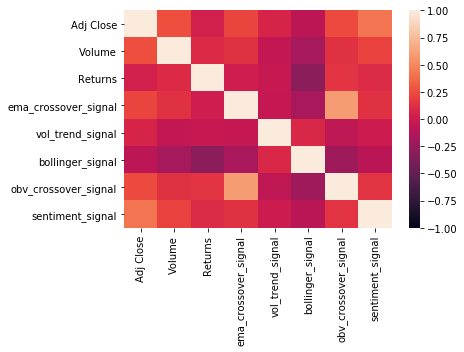

In [27]:
import seaborn as sns
sns.heatmap(return_signal_df.corr(), vmin = -1, vmax = 1)

In [28]:
# Saved to CSV
return_signal_df.drop(columns=["sentiment_signal"], inplace=True)
return_signal_df.to_csv('Returns and Signals.csv',index_label='Date')